## IMPORT NECCESSARY LIBRARY 

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler , OneHotEncoder 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 

## LOAD DATAFRAME   

In [2]:
# dataframe of anime information
df_anime = pd.read_csv('/kaggle/input/anime-recommendation-database-2020/anime.csv')
# dataframe of anime with synopsis
df_synopsis = pd.read_csv('/kaggle/input/anime-recommendation-database-2020/anime_with_synopsis.csv')
# dataframe of rating information 
df_score = pd.read_csv('/kaggle/input/anime-recommendation-database-2020/rating_complete.csv')

# status watching field decode which using in rating dataframe 
status_watching = {1: 'Currently Watching', 2: 'Completed',3 : 'On Hold', 4 : 'Dropped', 6 : 'Plan to Watch'}

## DATA PROCESSING

**Anime Information**

In [3]:
df_anime.shape

(17562, 35)

In [4]:
df_anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [5]:
df_anime.columns.unique()

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')

In [6]:
df_anime = df_anime.rename(columns = {'MAL_ID': "anime_id"})
df_anime = df_anime[['anime_id', 'Score', 'Genres','Ranked', 'Popularity','Members', 'Favorites', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']]

In [7]:
# synopsis anime 
df_synopsis.head()

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [8]:
df_synopsis = df_synopsis.rename(columns = {'MAL_ID':'anime_id'})

In [9]:
del df_synopsis['Score']
del df_synopsis['Genres']

df_anime = pd.merge(
    df_anime,
    df_synopsis,
    on='anime_id',
    how='inner' 
)

In [10]:
# remove nan and duplicate 
df_anime = df_anime.dropna()
df_anime = df_anime[~df_anime.isin(["Unknown"]).any(axis = 1)]

In [11]:
# check duplicated row 
df_anime[df_anime.duplicated(keep = False )]

,anime_id,Score,Genres,Ranked,Popularity,Members,Favorites,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Name,sypnopsis


**Rating Interation**

In [12]:
df_score.shape 

(57633278, 3)

In [13]:
df_score.head() 

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [14]:
# user id range 
df_score['user_id'].unique()

array([     0,      1,      2, ..., 353402, 353403, 353404])

In [15]:
# anime id range
df_score['anime_id'].unique()

array([  430,  1004,  3010, ..., 39435, 35746, 39627])

In [16]:
# remove unknown row
df_score = df_score[~df_score.isin(["Unknown"]).any(axis = 1)]

In [17]:
# check null 
df_score.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

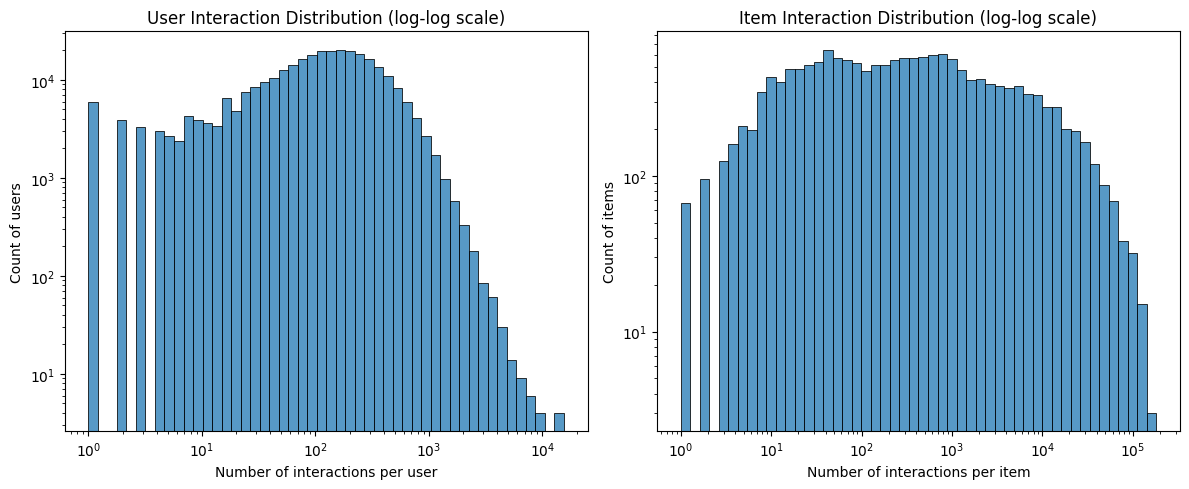

In [18]:
# number users interactions 
user_counts = df_score['user_id'].value_counts()

item_counts = df_score['anime_id'].value_counts()

# distribution of user counts
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(user_counts, bins=50, log_scale=(True, True))
plt.xlabel('Number of interactions per user')
plt.ylabel('Count of users')
plt.title('User Interaction Distribution (log-log scale)')

#  distribution of item counts 
plt.subplot(1,2,2)
sns.histplot(item_counts, bins=50, log_scale=(True, True))
plt.xlabel('Number of interactions per item')
plt.ylabel('Count of items')
plt.title('Item Interaction Distribution (log-log scale)')

plt.tight_layout()
plt.show()


In [23]:
MIN_USER_INTERACTIONS = 1000 
MIN_ITEM_INTERACTIONS = 10

# filter user 
valid_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index
# filter item 
valid_items = item_counts[item_counts >= MIN_ITEM_INTERACTIONS].index
df_score_1 = df_score[df_score['user_id'].isin(valid_users)]

df_score_2 = df_score_1[df_score_1['anime_id'].isin(df_anime['anime_id'].unique())]

In [24]:
animes_id = df_anime['anime_id'].unique()
df_score_2 = df_score_2[df_score_2['anime_id'].isin(animes_id)]

animes_id_2 = df_score_2['anime_id'].unique() 

df_anime = df_anime[df_anime['anime_id'].isin(animes_id_2)]

In [25]:
# final shape  
df_score_2.shape 


(6304092, 3)

In [26]:
df_anime.shape 

(9916, 19)

In [23]:
# save final data 
df_score_3.to_csv("data_rating.csv", index = False)
df_anime.to_csv("data_anime.csv", index = False)

## DATA DESCRIPTION

In [24]:
df_anime.head()

,anime_id,Score,Genres,Ranked,Popularity,Members,Favorites,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Name,sypnopsis
0,1,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",28.0,39,1251960,61971,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,Cowboy Bebop,"In the year 2071, humanity has colonized sever..."
1,5,8.39,"Action, Drama, Mystery, Sci-Fi, Space",159.0,518,273145,1174,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,Cowboy Bebop: Tengoku no Tobira,"other day, another bounty—such is the life of ..."
2,6,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",266.0,201,558913,12944,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,Trigun,"Vash the Stampede is the man with a $$60,000,0..."
3,7,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",2481.0,1467,94683,587,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,Witch Hunter Robin,ches are individuals with special powers like ...
4,8,6.98,"Adventure, Fantasy, Shounen, Supernatural",3710.0,4369,13224,18,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,Bouken Ou Beet,It is the dark century and the people are suff...


 <div style = "border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">

 <h2 align="left"><font color= #ff6200 > Dataframe Anime Description:</font></h2>

| __Variable__   | __Description__ |
|     :---       |       :---      |      
| __Score__      | Avergea score of the anime given from all users      |
| __Genres__     | Type movie  |
| __Episodes__   | Number of chapters |
| __Aired__      | Broadcast date |
| __Duration__   | Duration of the anime per episode |
| __Rating__     | Age limiting |
| __Favorites__  | the number of fans  |
| __Watching__    | The number of users watching |
